In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import random
import shap
import lime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Modifica questo con il percorso alla tua cartella
data_dir = "/content/drive/MyDrive/SL_Project/binary_one_type_split"

# Dimensione standard, modificabile
image_size = 256

# Trasformazioni da applicare: resize, tensorizzazione e normalizzazione
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # converte in [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # per 3 canali
])

# Dataset completo dalla cartella di training
full_train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

# Definisci le percentuali per train e validation
train_size = int(0.8 * len(full_train_dataset)) # 80% per il training effettivo
val_size = len(full_train_dataset) - train_size # 20% per la validation

# Split del dataset di training in train e validation sets
# Per riproducibilità dello split
g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=g)

# DataLoader per batch
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False) # Shuffle False for val
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False) # Shuffle False for test

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 2416
Validation dataset size: 604
Test dataset size: 755


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*32*32, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*32*32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # (3, 256, 256)
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Giorgio

In [ ]:
class TumorClassifier(nn.Module):
    def __init__(self, encoder, latent_dim=128):
        super().__init__()
        # Congela l'encoder, tranne ultimo layer
        for param in encoder.parameters():
            param.requires_grad = False

        for param in encoder[-2].parameters():
            param.requires_grad = True

        self.encoder = encoder  # encoder già addestrato

        # Head di classificazione
        self.classifier = nn.Sequential(
                    nn.Linear(latent_dim, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(0.3),

                    nn.Linear(128, 64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    nn.Dropout(0.3),

                    nn.Linear(64, 1)
                )

    def forward(self, x):
        z = self.encoder(x)  # ottieni le feature compresse
        return self.classifier(z)

# Giorgio

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(latent_dim=128)
model.load_state_dict(torch.load("/content/autoencoder.pth"))
model.eval()

encoder = model.encoder

# Crea il classificatore completo
classifier_model = TumorClassifier(encoder, latent_dim=128).to(device)

In [ ]:
classifier_model = TumorClassifierRes(encoder, latent_dim=128).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=1e-4)
num_epochs = 20

# --- Lists to store metrics for plotting ---
train_losses = []
val_losses = [] # New list for validation loss
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
# ------------------------------------------

for epoch in range(num_epochs):
    classifier_model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape (B, 1)

        outputs = classifier_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss) # Store average training loss

    # ----------------------
    # 🧪 Valutazione su VALIDATION set
    classifier_model.eval()
    val_loss = 0.0 # Track validation loss
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader: # Use val_loader here
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = classifier_model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0) # Accumulate validation loss

            preds = torch.sigmoid(outputs) > 0.75  # binarizza le predizioni
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset) # Calculate average validation loss
    val_losses.append(avg_val_loss) # Store average validation loss

    # Calcolo metriche per il validation set
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_prec = precision_score(all_val_labels, all_val_preds, zero_division=0)
    val_rec = recall_score(all_val_labels, all_val_preds, zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)

    # Store validation metrics
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1_scores.append(val_f1)
    # ------------------

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1:.4f}")

Using device: cuda
Epoch [1/20]
Train Loss: 0.6043 | Acc: 0.6106 | Prec: 0.9077 | Rec: 0.2950 | F1: 0.4453
Epoch [2/20]
Train Loss: 0.4605 | Acc: 0.6874 | Prec: 0.9607 | Rec: 0.4275 | F1: 0.5917
Epoch [3/20]
Train Loss: 0.3762 | Acc: 0.7974 | Prec: 0.9768 | Rec: 0.6325 | F1: 0.7678
Epoch [4/20]
Train Loss: 0.3110 | Acc: 0.8556 | Prec: 0.9619 | Rec: 0.7575 | F1: 0.8476
Epoch [5/20]
Train Loss: 0.2635 | Acc: 0.8861 | Prec: 0.9673 | Rec: 0.8125 | F1: 0.8832
Epoch [6/20]
Train Loss: 0.2306 | Acc: 0.8980 | Prec: 0.9681 | Rec: 0.8350 | F1: 0.8966
Epoch [7/20]
Train Loss: 0.2038 | Acc: 0.9192 | Prec: 0.9695 | Rec: 0.8750 | F1: 0.9198
Epoch [8/20]
Train Loss: 0.1805 | Acc: 0.9258 | Prec: 0.9725 | Rec: 0.8850 | F1: 0.9267
Epoch [9/20]
Train Loss: 0.1616 | Acc: 0.9417 | Prec: 0.9785 | Rec: 0.9100 | F1: 0.9430
Epoch [10/20]
Train Loss: 0.1431 | Acc: 0.9563 | Prec: 0.9766 | Rec: 0.9400 | F1: 0.9580
Epoch [11/20]
Train Loss: 0.1265 | Acc: 0.9589 | Prec: 0.9792 | Rec: 0.9425 | F1: 0.9605
Epoch [12/2

In [ ]:
# --- Plotting the trends ---
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(15, 6)) # Adjusted height for better readability

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss', linestyle='--') # Plot validation loss
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Metrics (Accuracy, Precision, Recall, F1-Score)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, val_precisions, label='Validation Precision')
plt.plot(epochs_range, val_recalls, label='Validation Recall')
plt.plot(epochs_range, val_f1_scores, label='Validation F1-Score')
plt.title('Validation Metrics per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05) # Ensure y-axis for scores goes from 0 to 1

plt.tight_layout()
plt.show()

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, target_class=None):
        self.model.eval()

        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            # If target_class is not specified, take the class with the highest probability
            target_class = torch.sigmoid(output).argmax().item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass
        one_hot_output = torch.zeros_like(output)
        one_hot_output[:, target_class] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        # Get gradients and activations
        guided_gradients = self.gradients
        activations = self.activations

        # Compute weights (global average pooling of gradients)
        weights = torch.mean(guided_gradients, dim=[2, 3], keepdim=True)

        # Compute CAM
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam) # Apply ReLU to remove negative values

        # Normalize CAM to 0-1
        cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().detach().cpu().numpy()


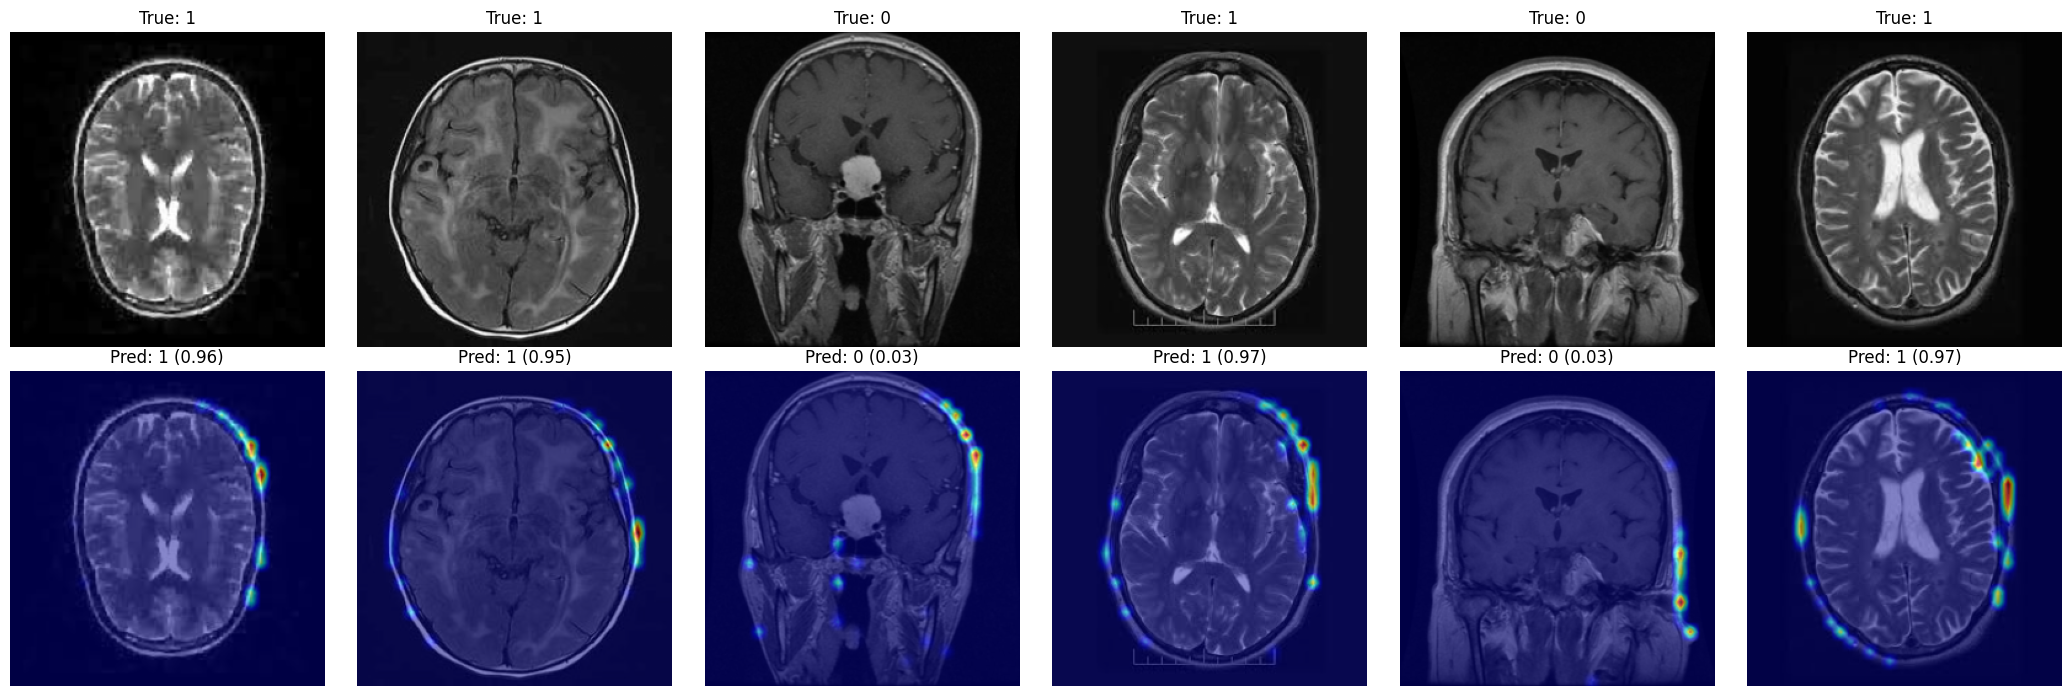

In [ ]:
# --- Usage Example for Grad-CAM ---
import random
# Load a sample image from the test set
model.eval() # Ensure the autoencoder's encoder is in eval mode
classifier_model.eval() # Ensure the classifier is in eval mode

with torch.no_grad():
    images, labels = next(iter(test_loader))
    sample_image = images[0].unsqueeze(0).to(device) # Take the first image
    true_label = labels[0].item()

# Instantiate GradCAM
# We need to target the last convolutional layer of the encoder within the classifier model
# In your Autoencoder, the encoder's last Conv2d layer is at index 6:
# nn.Sequential(
#     nn.Conv2d(3, 32, ...), # 0
#     nn.BatchNorm2d(32),   # 1
#     nn.ReLU(),            # 2
#     nn.Conv2d(32, 64, ...), # 3
#     nn.BatchNorm2d(64),   # 4
#     nn.ReLU(),            # 5
#     nn.Conv2d(64, 128, ...), # 6 <--- Target layer for Grad-CAM
#     nn.BatchNorm2d(128),  # 7
#     nn.ReLU(),            # 8
#     nn.Flatten(),         # 9
#     nn.Linear(128*32*32, latent_dim) # 10
# )
grad_cam = GradCAM(classifier_model, classifier_model.encoder[6])

num_images_to_show = 6 # Number of random images to visualize

# --- MODIFICATION START ---
# Get random indices from the test_dataset
total_test_samples = len(test_dataset)
random_indices = random.sample(range(total_test_samples), num_images_to_show)

# Adjust figure size dynamically
# We'll plot two rows: Original Image and Superimposed CAM for predicted class
plt.figure(figsize=(num_images_to_show * 3.5, 7)) # Adjusted size for better display
# --- MODIFICATION END ---

for i, idx in enumerate(random_indices):
    # Retrieve the image and label using the random index from the dataset
    # We need to manually apply the transform if the dataset doesn't do it on __getitem__
    # (ImageFolder with transform in its constructor already handles it)
    sample_data, true_label = test_dataset[idx]

    # Add batch dimension and move to device
    sample_image = sample_data.unsqueeze(0).to(device)
    true_label = true_label # Label is already an int

    # Ensure the input image for Grad-CAM has requires_grad=True
    sample_image_for_cam = sample_image.clone().detach().requires_grad_(True)

    # Get CAM (e.g., for predicted class)
    # The GradCAM.__call__ method will automatically determine the target class if target_class=None
    cam_output = grad_cam(sample_image_for_cam)

    # De-normalize and display the original image
    original_image_display = (sample_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5

    # Overlay CAM on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1] # Convert BGR to RGB

    original_image_display_float = np.float32(original_image_display)

    # Superimpose the heatmap on the original image
    superimposed_img = original_image_display_float + heatmap
    superimposed_img = superimposed_img / np.max(superimposed_img) # Normalize to prevent clipping

    # Get predicted class and probability for display
    # Use the original sample_image (no requires_grad) for simple prediction
    with torch.no_grad():
        predicted_logit = classifier_model(sample_image).item()
        predicted_prob = torch.sigmoid(torch.tensor(predicted_logit)).item()
        predicted_class = 1 if predicted_prob > 0.5 else 0 # Assuming 0.5 threshold for prediction


    # Plotting - Adjusted subplot indexing for random order
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(original_image_display)
    plt.title(f"True: {true_label}")
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(superimposed_img)
    plt.title(f"Pred: {predicted_class} ({predicted_prob:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Gheb

In [5]:
class ResNetBlock1D(nn.Module):
    """
    A simple ResNet-like block for 1D feature vectors.
    Consists of two linear layers with BatchNorm and ReLU,
    and a skip connection.
    """
    def __init__(self, in_features, out_features, stride=1):
        super().__init__()
        # If in_features != out_features, we need a projection for the skip connection
        self.downsample = None
        if stride != 1 or in_features != out_features:
            # For 1D, stride isn't directly applicable as it is in Conv2d.
            # Here, 'stride' essentially means a change in feature dimension.
            # If in_features != out_features, we project the skip connection.
            self.downsample = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features)
            )

        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(inplace=True), # inplace=True can save memory
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.block(x)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity # Add the skip connection
        out = self.relu(out)
        return out

In [6]:
class TumorClassifierRes(nn.Module):
    def __init__(self, encoder, latent_dim=128):
        super().__init__()
        # Congela l'encoder, tranne ultimo layer (as per your original code)
        for param in encoder.parameters():
            param.requires_grad = False

        for i in range(6, len(encoder)): # Unfreeze from index 6 till the end of encoder
            for param in encoder[i].parameters():
                param.requires_grad = True

        self.encoder = encoder  # encoder già addestrato

        # --- MODIFIED CLASSIFIER HEAD ---
        self.classifier = nn.Sequential(
            # Initial layer to potentially expand features if desired, or just pass latent_dim directly
            # You could start with a block immediately if latent_dim is your desired block input size
            # Here, let's make it more explicitly multi-block
            ResNetBlock1D(latent_dim, 128), # First block: latent_dim -> 128
            nn.Dropout(0.3), # Dropout can be placed between blocks or after them

            ResNetBlock1D(128, 64),  # Second block: 128 -> 64
            nn.Dropout(0.3),

            # Final classification layer (output a single logit for binary classification)
            nn.Linear(64, 1) # Output 1 for BCEWithLogitsLoss
        )

    def forward(self, x):
        z = self.encoder(x)  # get compressed features from encoder
        return self.classifier(z)

# SmoothGrad

In [ ]:
model = Autoencoder(latent_dim=128)
model.load_state_dict(torch.load("/content/autoencoder.pth"))
model.eval()

encoder = model.encoder

# Crea il classificatore completo
classifier_model = TumorClassifierRes(encoder, latent_dim=128).to(device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=1e-4)
num_epochs = 50

# --- Lists to store metrics for plotting ---
train_losses = []
val_losses = [] # New list for validation loss
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
# ------------------------------------------

for epoch in range(num_epochs):
    classifier_model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape (B, 1)

        outputs = classifier_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss) # Store average training loss

    # ----------------------
    # 🧪 Valutazione su VALIDATION set
    classifier_model.eval()
    val_loss = 0.0 # Track validation loss
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader: # Use val_loader here
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = classifier_model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0) # Accumulate validation loss

            preds = torch.sigmoid(outputs) > 0.75  # binarizza le predizioni
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset) # Calculate average validation loss
    val_losses.append(avg_val_loss) # Store average validation loss

    # Calcolo metriche per il validation set
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_prec = precision_score(all_val_labels, all_val_preds, zero_division=0)
    val_rec = recall_score(all_val_labels, all_val_preds, zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)

    # Store validation metrics
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1_scores.append(val_f1)
    # ------------------

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1:.4f}")

Using device: cuda
Epoch [1/50]
Train Loss: 0.2071 | Val Loss: 0.2015 | Val Acc: 0.8940 | Val Prec: 0.9792 | Val Rec: 0.8294 | Val F1: 0.8981
Epoch [2/50]
Train Loss: 0.1759 | Val Loss: 0.1840 | Val Acc: 0.8957 | Val Prec: 0.9792 | Val Rec: 0.8324 | Val F1: 0.8998
Epoch [3/50]
Train Loss: 0.1478 | Val Loss: 0.1647 | Val Acc: 0.9089 | Val Prec: 0.9798 | Val Rec: 0.8559 | Val F1: 0.9137
Epoch [4/50]
Train Loss: 0.1310 | Val Loss: 0.1439 | Val Acc: 0.9238 | Val Prec: 0.9836 | Val Rec: 0.8794 | Val F1: 0.9286
Epoch [5/50]
Train Loss: 0.1079 | Val Loss: 0.1338 | Val Acc: 0.9371 | Val Prec: 0.9840 | Val Rec: 0.9029 | Val F1: 0.9417
Epoch [6/50]
Train Loss: 0.0930 | Val Loss: 0.1191 | Val Acc: 0.9404 | Val Prec: 0.9841 | Val Rec: 0.9088 | Val F1: 0.9450
Epoch [7/50]
Train Loss: 0.0808 | Val Loss: 0.1126 | Val Acc: 0.9470 | Val Prec: 0.9873 | Val Rec: 0.9176 | Val F1: 0.9512
Epoch [8/50]
Train Loss: 0.0668 | Val Loss: 0.0996 | Val Acc: 0.9503 | Val Prec: 0.9844 | Val Rec: 0.9265 | Val F1: 0.95

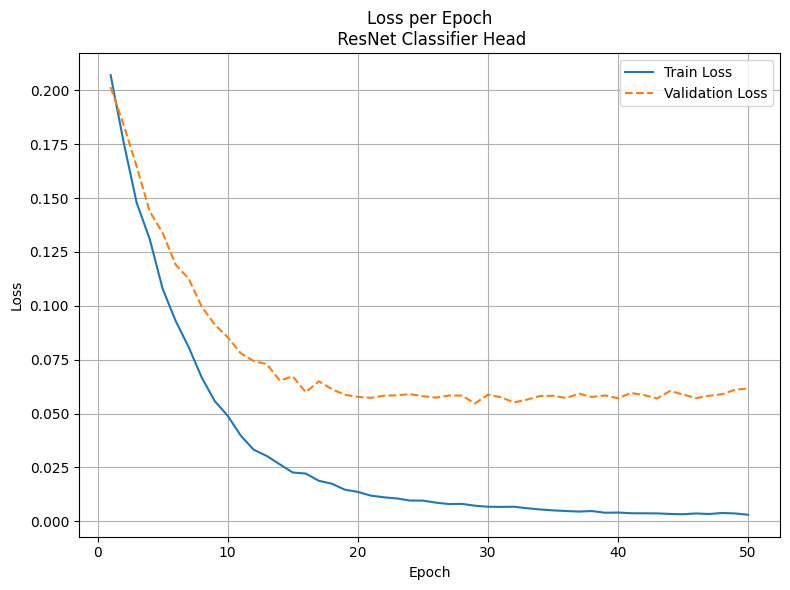

In [ ]:
num_epochs = len(train_losses) # Ensure this reflects the actual number of epochs
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6)) # Create a new figure for this plot
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss', linestyle='--')
plt.title('Loss per Epoch\n ResNet Classifier Head')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout
plt.show() # Close the figure to free up memory (important in loops or when making many plots)

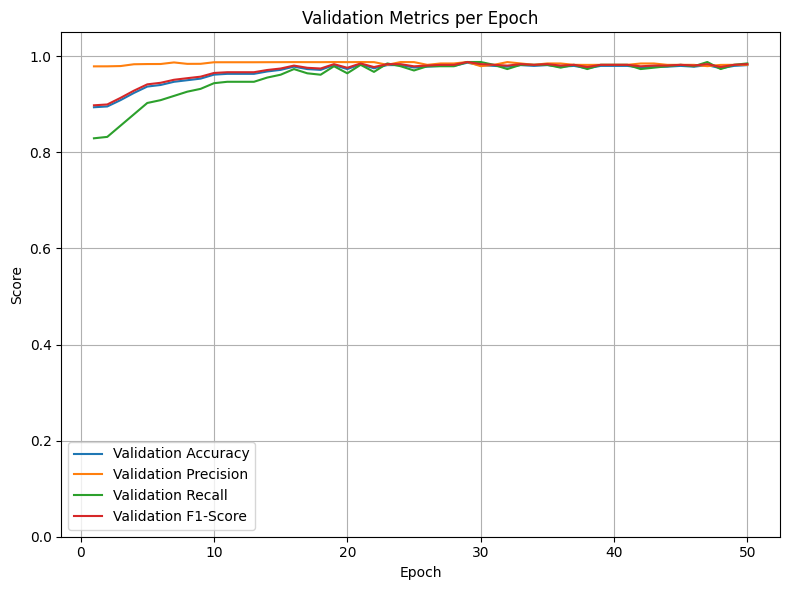

In [ ]:
# --- Plot 2: Validation Metrics (Accuracy, Precision, Recall, F1-Score) ---
plt.figure(figsize=(8, 6)) # Create another new figure for this plot
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, val_precisions, label='Validation Precision')
plt.plot(epochs_range, val_recalls, label='Validation Recall')
plt.plot(epochs_range, val_f1_scores, label='Validation F1-Score')
plt.title('Validation Metrics per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05) # Ensure y-axis for scores goes from 0 to 1
plt.tight_layout() # Adjust layout
plt.show()

In [ ]:
torch.save(classifier_model.state_dict(), 'autoencoder_resnest.pth')

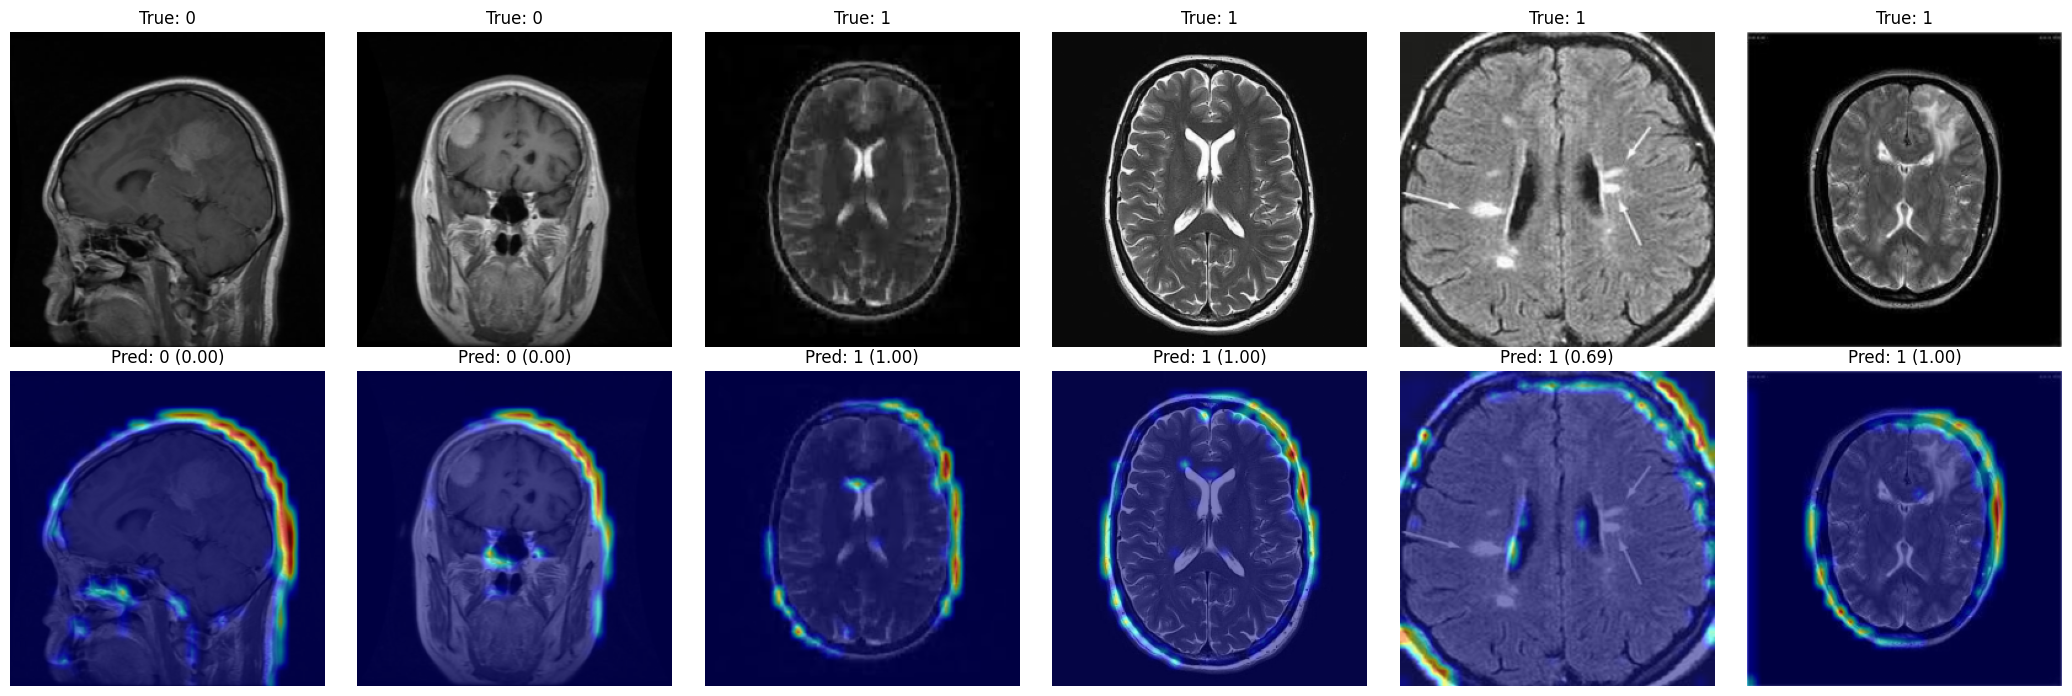

In [ ]:
# --- Usage Example for Grad-CAM ---
import random
# Load a sample image from the test set
model.eval() # Ensure the autoencoder's encoder is in eval mode
classifier_model.eval() # Ensure the classifier is in eval mode

with torch.no_grad():
    images, labels = next(iter(test_loader))
    sample_image = images[0].unsqueeze(0).to(device) # Take the first image
    true_label = labels[0].item()

grad_cam = GradCAM(classifier_model, classifier_model.encoder[6])

num_images_to_show = 6 # Number of random images to visualize

# --- MODIFICATION START ---
# Get random indices from the test_dataset
total_test_samples = len(test_dataset)
random_indices = random.sample(range(total_test_samples), num_images_to_show)

# Adjust figure size dynamically
# We'll plot two rows: Original Image and Superimposed CAM for predicted class
plt.figure(figsize=(num_images_to_show * 3.5, 7)) # Adjusted size for better display
# --- MODIFICATION END ---

for i, idx in enumerate(random_indices):
    # Retrieve the image and label using the random index from the dataset
    # We need to manually apply the transform if the dataset doesn't do it on __getitem__
    # (ImageFolder with transform in its constructor already handles it)
    sample_data, true_label = test_dataset[idx]

    # Add batch dimension and move to device
    sample_image = sample_data.unsqueeze(0).to(device)
    true_label = true_label # Label is already an int

    # Ensure the input image for Grad-CAM has requires_grad=True
    sample_image_for_cam = sample_image.clone().detach().requires_grad_(True)

    # Get CAM (e.g., for predicted class)
    # The GradCAM.__call__ method will automatically determine the target class if target_class=None
    cam_output = grad_cam(sample_image_for_cam)

    # De-normalize and display the original image
    original_image_display = (sample_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5

    # Overlay CAM on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1] # Convert BGR to RGB

    original_image_display_float = np.float32(original_image_display)

    # Superimpose the heatmap on the original image
    superimposed_img = original_image_display_float + heatmap
    superimposed_img = superimposed_img / np.max(superimposed_img) # Normalize to prevent clipping

    # Get predicted class and probability for display
    # Use the original sample_image (no requires_grad) for simple prediction
    with torch.no_grad():
        predicted_logit = classifier_model(sample_image).item()
        predicted_prob = torch.sigmoid(torch.tensor(predicted_logit)).item()
        predicted_class = 1 if predicted_prob > 0.5 else 0 # Assuming 0.5 threshold for prediction


    # Plotting - Adjusted subplot indexing for random order
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(original_image_display)
    plt.title(f"True: {true_label}")
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(superimposed_img)
    plt.title(f"Pred: {predicted_class} ({predicted_prob:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

# LIME

Processing Image 1/10: True Label: 0, Predicted Class: 0 (Prob: 0.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 2/10: True Label: 0, Predicted Class: 0 (Prob: 0.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 3/10: True Label: 0, Predicted Class: 0 (Prob: 0.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 4/10: True Label: 0, Predicted Class: 0 (Prob: 0.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 5/10: True Label: 0, Predicted Class: 0 (Prob: 0.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 6/10: True Label: 1, Predicted Class: 1 (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 7/10: True Label: 1, Predicted Class: 1 (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 8/10: True Label: 1, Predicted Class: 1 (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 9/10: True Label: 1, Predicted Class: 1 (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Image 10/10: True Label: 1, Predicted Class: 1 (Prob: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

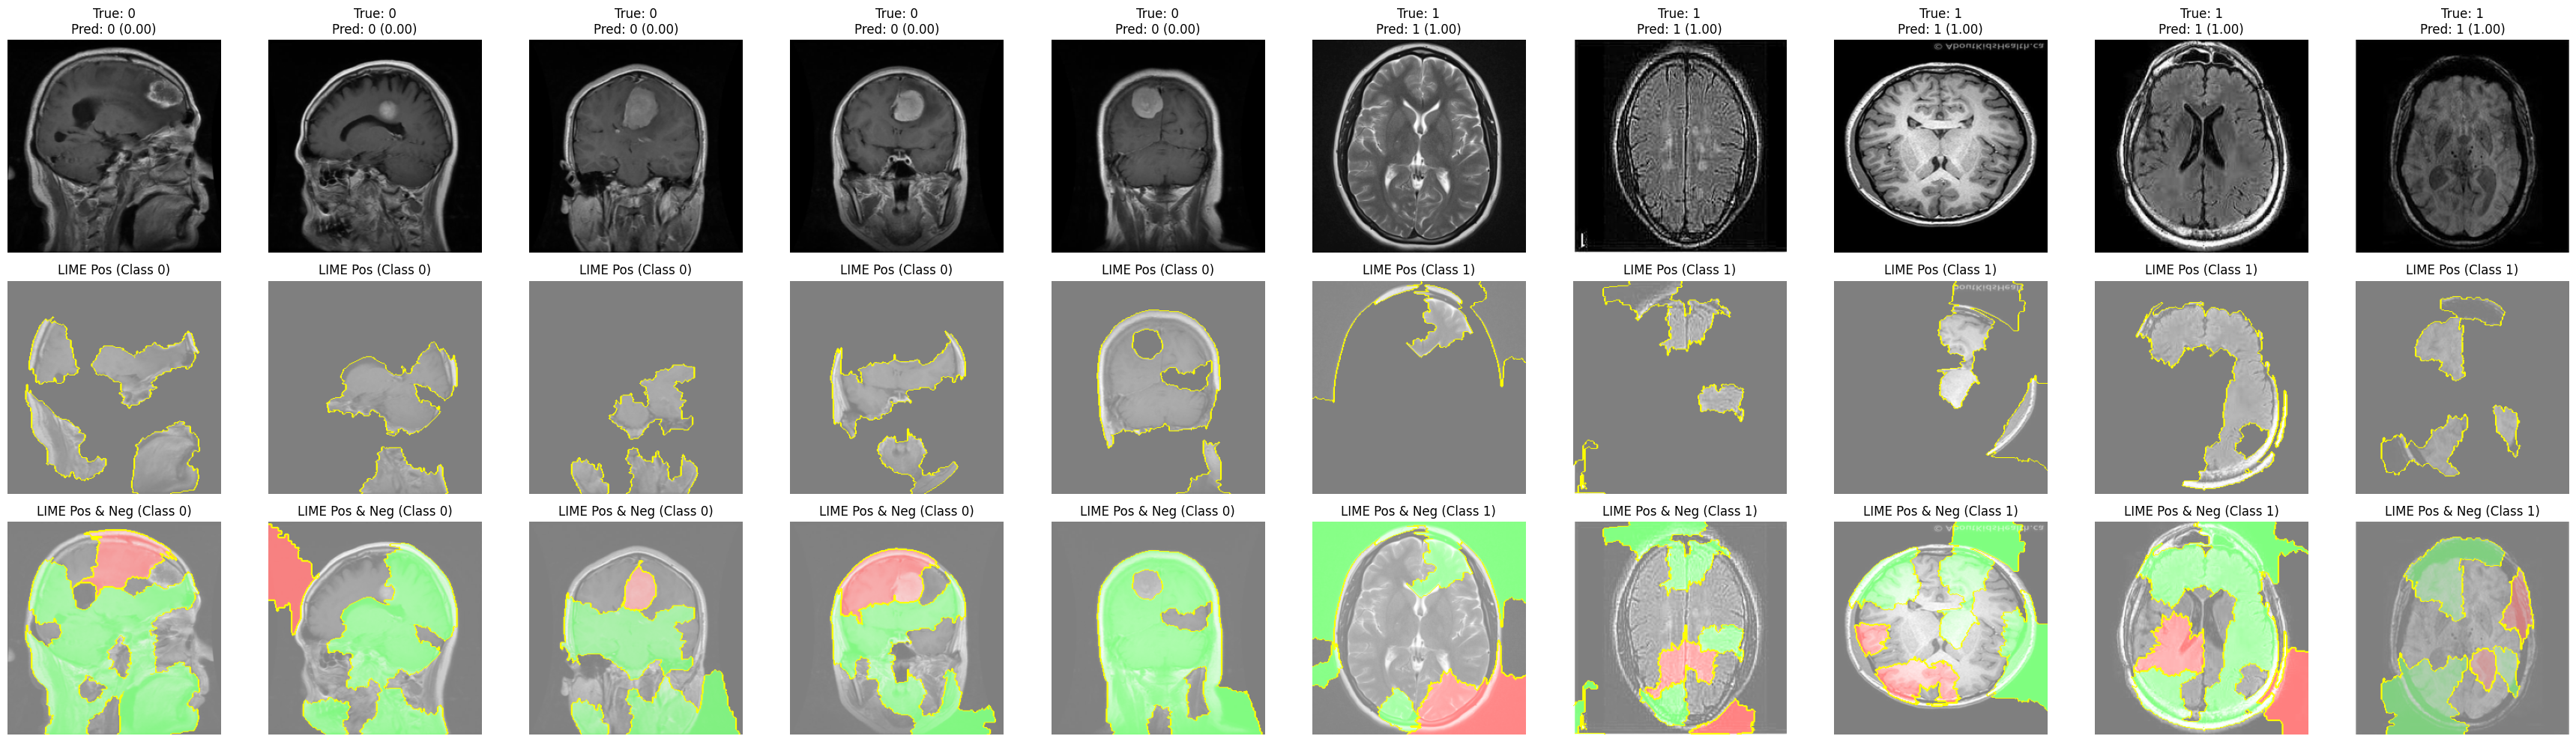


Finished LIME explanations for selected images.


In [ ]:
# Import LIME components
from lime import lime_image
from skimage.segmentation import mark_boundaries # For visualizing LIME results

# --- Assuming all your previous definitions (Autoencoder, TumorClassifier,
#     GradCAM, device, test_dataset, transform) are already run ---

# Ensure your model is in evaluation mode and on the correct device
classifier_model.to(device)
classifier_model.eval()

# --- Define the prediction function for LIME (as you provided) ---
def predict_proba(images_np):
    """
    LIME needs a function that takes a NumPy array of images (already preprocessed)
    and returns a NumPy array of prediction probabilities for each class.

    Args:
        images_np (numpy.ndarray): A batch of images. Shape (N, H, W, C) where
                                   N is batch size, H/W are height/width, C is channels (RGB).
                                   LIME typically passes images in this format.

    Returns:
        numpy.ndarray: Prediction probabilities. Shape (N, 2) for binary classification
                       (probability of class 0, probability of class 1).
    """
    images_torch = torch.from_numpy(images_np).float().permute(0, 3, 1, 2)

    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(images_torch.device)
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(images_torch.device)
    images_torch = (images_torch - mean) / std

    images_torch = images_torch.to(device)

    with torch.no_grad():
        outputs = classifier_model(images_torch)
        probs = torch.sigmoid(outputs) # Get probability for class 1

    prob_class_1 = probs.cpu().numpy() # Shape (N, 1)
    prob_class_0 = 1 - prob_class_1 # Shape (N, 1)

    return np.hstack((prob_class_0, prob_class_1))


# --- LIME Explainer Initialization ---
explainer = lime_image.LimeImageExplainer()

# --- Select images for both classes ---
num_images_per_class = 5

# Collect indices of each class
class0_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 0]
class1_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 1]

# Randomly sample desired number of images from each class
selected_indices_class0 = random.sample(class0_indices, num_images_per_class)
selected_indices_class1 = random.sample(class1_indices, num_images_per_class)

# Combine selected indices from both classes
all_selected_indices = selected_indices_class0 + selected_indices_class1

# --- Adjust figure size for 3 rows (Original, LIME Pos, LIME Pos & Neg) and 10 columns (5 per class) ---
# Each image will have its own set of 3 subplots vertically.
# We'll use a grid of (num_rows * num_images_per_class * 2, num_cols)
# Let's try 3 rows (original, lime_pos, lime_pos_neg) * 2 classes = 6 rows in total conceptually
# And num_images_per_class columns for each.
# A simpler layout is: each image gets 3 plots (original, pos, neg), and we stack these side-by-side.
# Total columns = num_images_per_class * 2 (for both classes)
# Total rows = 3 (for original, pos, neg explanation)

num_total_images = num_images_per_class * 2 # 5 from class 0 + 5 from class 1
plt.figure(figsize=(num_total_images * 3.5, 10)) # Adjust figure size for width and height


# --- Loop through selected images and generate LIME explanations ---
for i, idx in enumerate(all_selected_indices):
    sample_data, true_label = test_dataset[idx]

    # Denormalize image for LIME's input and visualization
    original_image_for_lime = (sample_data.cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5

    # Get the model's prediction for this specific image
    with torch.no_grad():
        sample_image_input = sample_data.unsqueeze(0).to(device)
        predicted_logit = classifier_model(sample_image_input).item()
        predicted_prob = torch.sigmoid(torch.tensor(predicted_logit)).item()
        predicted_class = 1 if predicted_prob > 0.5 else 0

    print(f"Processing Image {i+1}/{num_total_images}: True Label: {true_label}, Predicted Class: {predicted_class} (Prob: {predicted_prob:.2f})")

    # Generate LIME explanation for the predicted class
    explanation_class_to_explain = predicted_class

    explanation = explainer.explain_instance(
        original_image_for_lime,
        predict_proba,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get image and mask for positive contributions
    temp_pos, mask_pos = explanation.get_image_and_mask(
        explanation_class_to_explain,
        positive_only=True,
        num_features=5,
        hide_rest=True
    )

    # Get image and mask for positive and negative contributions
    temp_neg, mask_neg = explanation.get_image_and_mask(
        explanation_class_to_explain,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    # --- Plotting for current image ---
    # Plotting grid will be (rows, cols, index)
    # Rows = 3 (Original, Pos Only, Pos & Neg)
    # Cols = num_total_images

    # Original Image
    plt.subplot(3, num_total_images, i + 1)
    plt.imshow(original_image_for_lime)
    plt.title(f"True: {true_label}\nPred: {predicted_class} ({predicted_prob:.2f})")
    plt.axis('off')

    # LIME Explanation (Positive contributions only)
    plt.subplot(3, num_total_images, i + 1 + num_total_images)
    plt.imshow(mark_boundaries(temp_pos / 2 + 0.5, mask_pos))
    plt.title(f"LIME Pos (Class {explanation_class_to_explain})")
    plt.axis('off')

    # LIME Explanation (Positive and Negative contributions)
    plt.subplot(3, num_total_images, i + 1 + 2 * num_total_images)
    plt.imshow(mark_boundaries(temp_neg / 2 + 0.5, mask_neg))
    plt.title(f"LIME Pos & Neg (Class {explanation_class_to_explain})")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nFinished LIME explanations for selected images.")

#SHAP

In [8]:
model = Autoencoder(latent_dim=128)
model.load_state_dict(torch.load("/content/autoencoder.pth"))
model.eval()

encoder = model.encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Crea il classificatore completo
classifier_model = TumorClassifierRes(encoder, latent_dim=128).to(device)

# Load the classifier model state dictionary, mapping CUDA tensors to CPU if necessary
classifier_model.load_state_dict(torch.load("/content/autoencoder_resnest.pth", map_location=torch.device('cpu')))
classifier_model.eval()

TumorClassifierRes(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): ResNetBlock1D(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Linear(in_features


Preparing background data for SHAP...
Background data shape for SHAP: torch.Size([640, 3, 256, 256])
SHAP GradientExplainer initialized.

Explaining 5 random images per class...

--- Explaining images for Class: 'meningioma' (Label: 0) ---
Processing image 1/5 for class 'meningioma' (Test Dataset Index: 47)...
  Model raw logit prediction: -6.8581
  Model predicted probability: 0.0010
  Model predicted label: 0 ('meningioma')


<Figure size 800x600 with 0 Axes>

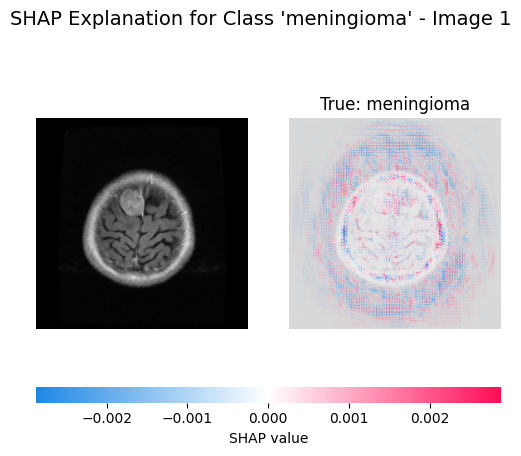

Processing image 2/5 for class 'meningioma' (Test Dataset Index: 284)...
  Model raw logit prediction: -6.5161
  Model predicted probability: 0.0015
  Model predicted label: 0 ('meningioma')


<Figure size 800x600 with 0 Axes>

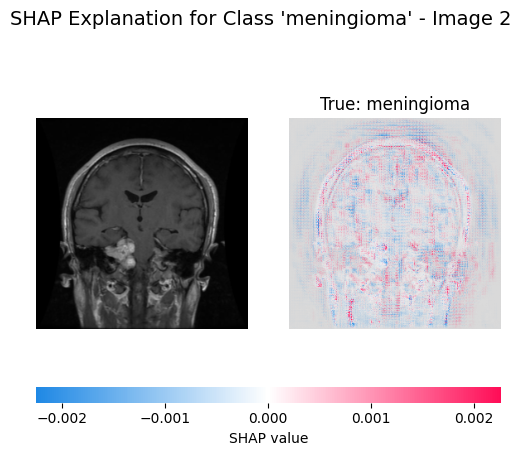

Processing image 3/5 for class 'meningioma' (Test Dataset Index: 281)...
  Model raw logit prediction: -7.6057
  Model predicted probability: 0.0005
  Model predicted label: 0 ('meningioma')


<Figure size 800x600 with 0 Axes>

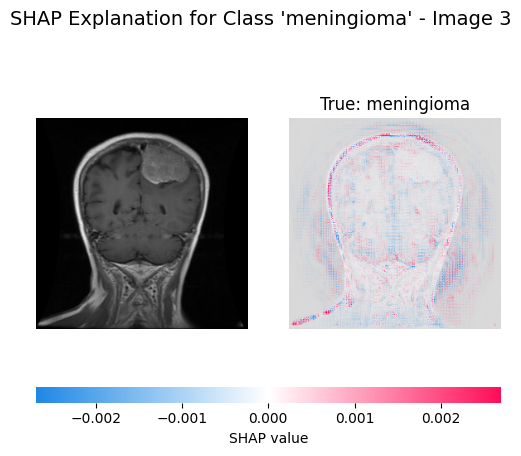

Processing image 4/5 for class 'meningioma' (Test Dataset Index: 197)...
  Model raw logit prediction: -7.4671
  Model predicted probability: 0.0006
  Model predicted label: 0 ('meningioma')


<Figure size 800x600 with 0 Axes>

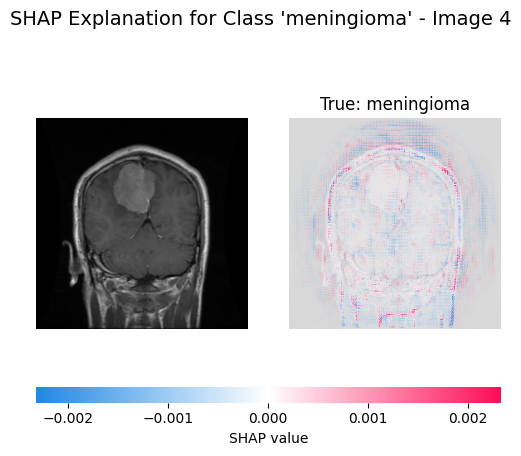

Processing image 5/5 for class 'meningioma' (Test Dataset Index: 81)...
  Model raw logit prediction: -5.9375
  Model predicted probability: 0.0026
  Model predicted label: 0 ('meningioma')


<Figure size 800x600 with 0 Axes>

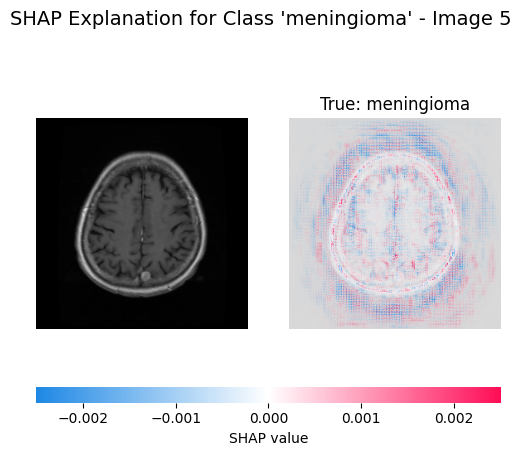


--- Explaining images for Class: 'notumor' (Label: 1) ---
Processing image 1/5 for class 'notumor' (Test Dataset Index: 407)...
  Model raw logit prediction: 3.1195
  Model predicted probability: 0.9577
  Model predicted label: 1 ('notumor')


<Figure size 800x600 with 0 Axes>

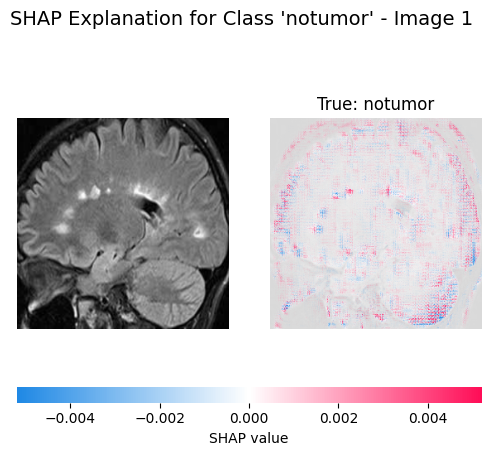

Processing image 2/5 for class 'notumor' (Test Dataset Index: 552)...
  Model raw logit prediction: 6.5189
  Model predicted probability: 0.9985
  Model predicted label: 1 ('notumor')


<Figure size 800x600 with 0 Axes>

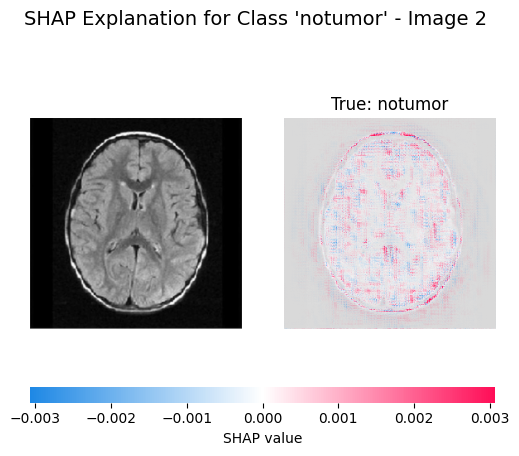

Processing image 3/5 for class 'notumor' (Test Dataset Index: 568)...
  Model raw logit prediction: 6.7676
  Model predicted probability: 0.9989
  Model predicted label: 1 ('notumor')


<Figure size 800x600 with 0 Axes>

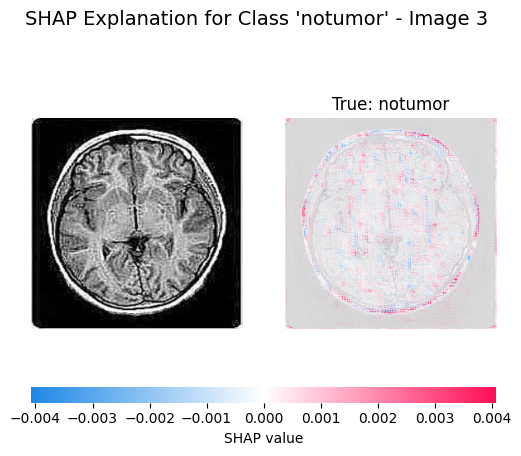

Processing image 4/5 for class 'notumor' (Test Dataset Index: 473)...
  Model raw logit prediction: 6.5819
  Model predicted probability: 0.9986
  Model predicted label: 1 ('notumor')


<Figure size 800x600 with 0 Axes>

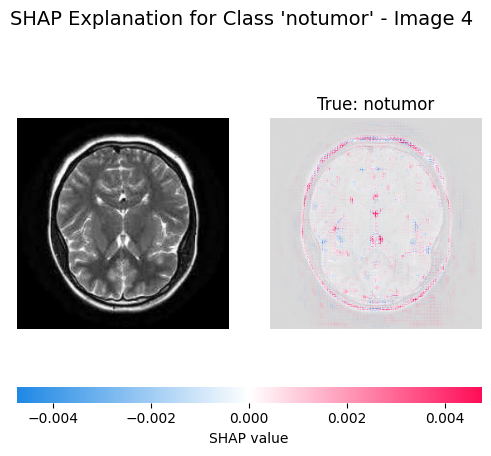

Processing image 5/5 for class 'notumor' (Test Dataset Index: 551)...
  Model raw logit prediction: 7.5468
  Model predicted probability: 0.9995
  Model predicted label: 1 ('notumor')


<Figure size 800x600 with 0 Axes>

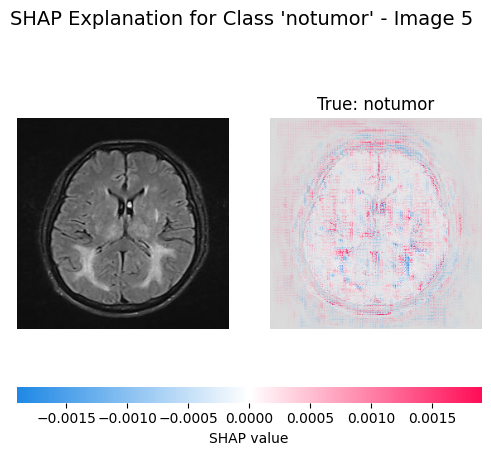


All SHAP explanation processes complete for selected images.


In [14]:
# --- Prepare background data for SHAP GradientExplainer ---
print("Preparing background data for SHAP...")
background_data = []
num_background_batches = 5 # Adjust based on available RAM and desired speed
for i, (images, _) in enumerate(train_loader):
    if i >= num_background_batches:
        break
    background_data.append(images)
background = torch.cat(background_data, dim=0).to(device)
print(f"Background data shape for SHAP: {background.shape}")

# --- Initialize SHAP GradientExplainer ---
explainer = shap.GradientExplainer(classifier_model, background)
print("SHAP GradientExplainer initialized.")

# --- Select and Explain 5 random images per class ---
num_images_per_class = 5
class_names = test_dataset.classes # Get class names, e.g., ['class0', 'class1']

# Separate indices by class
class_indices = {i: [] for i in range(len(class_names))}
for idx, (_, label) in enumerate(test_dataset):
    class_indices[label].append(idx)

print(f"\nExplaining {num_images_per_class} random images per class...")

for class_label in sorted(class_indices.keys()):
    class_name = class_names[class_label]
    print(f"\n--- Explaining images for Class: '{class_name}' (Label: {class_label}) ---")

    # Randomly select N images from the current class's indices
    selected_indices = random.sample(class_indices[class_label], min(num_images_per_class, len(class_indices[class_label])))

    for i, idx in enumerate(selected_indices):
        print(f"Processing image {i+1}/{num_images_per_class} for class '{class_name}' (Test Dataset Index: {idx})...")

        # Get the image and its true label
        image_to_explain_tensor, true_label = test_dataset[idx]
        image_to_explain = image_to_explain_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

        # Get the model's prediction for the image
        with torch.no_grad():
            logit_prediction = classifier_model(image_to_explain).item()
            predicted_probability = torch.sigmoid(torch.tensor(logit_prediction)).item()
            predicted_label = 1 if predicted_probability >= 0.5 else 0

        print(f"  Model raw logit prediction: {logit_prediction:.4f}")
        print(f"  Model predicted probability: {predicted_probability:.4f}")
        print(f"  Model predicted label: {predicted_label} ('{class_names[predicted_label]}')")

        # Compute SHAP values
        # shap_values will be a list of arrays (one for each model output).
        # Since your model has a single output, shap_values will be [numpy_array_of_shap_values]
        shap_values_raw = explainer.shap_values(image_to_explain)

        # For single output models, shap_values_raw[0] contains the actual SHAP values
        # for the current input. It will be (1, C, H, W) because of the batch dimension.
        # We need (C, H, W) for plotting.
        shap_values_for_plot = shap_values_raw[0][0]

        # Unnormalize the image for plotting
        img_unnormalized = (image_to_explain_tensor.cpu().numpy() * 0.5) + 0.5
        img_unnormalized = np.clip(img_unnormalized, 0, 1)
        # Reshape from (C, H, W) to (H, W, C) for matplotlib
        img_unnormalized = np.transpose(img_unnormalized, (1, 2, 0))

        # Display SHAP heatmap
        plt.figure(figsize=(8, 6)) # Create a new figure for each plot
        shap.image_plot(shap_values_for_plot, img_unnormalized,
                        labels=[f"True: {class_names[true_label]}", f"Predicted: {class_names[predicted_label]} (P={predicted_probability:.2f})"],
                        show=False)
        plt.suptitle(f"SHAP Explanation for Class '{class_name}' - Image {i+1}", fontsize=14)
        plt.show()

print("\nAll SHAP explanation processes complete for selected images.")

# Conformal Prediction

In [ ]:
# --- Assuming your TumorClassifier class (with ResNet-like head)
#     and the Autoencoder architecture are already defined.
#     Also assuming 'device' is defined ('cuda' or 'cpu').
#     And 'test_dataset' is available (e.g., from ImageFolder).

# Ensure classifier_model is loaded and on the correct device
classifier_model.to(device)
classifier_model.eval() # Set model to evaluation mode

# --- 1. Data Split (Calibration and Final Test Sets) ---
# It's crucial that the calibration set has NOT been used for training.
# We'll split the existing 'test_dataset' into calibration and final test.
# Adjust these ratios as needed. A common split is 50/50 or 60/40 for test/calibration.
# For demonstration, let's use 50% for calibration and 50% for final test.
# Ensure you have enough samples in your test_dataset for this split.

calibration_ratio = 0.5 # Proportion of test_dataset to use for calibration
num_test_samples = len(test_dataset)
num_calibration_samples = int(calibration_ratio * num_test_samples)
num_final_test_samples = num_test_samples - num_calibration_samples

# Ensure reproducibility of the split
g = torch.Generator().manual_seed(42)

calibration_dataset, final_test_dataset = random_split(
    test_dataset,
    [num_calibration_samples, num_final_test_samples],
    generator=g # Use generator for reproducible split
)

calibration_loader = DataLoader(calibration_dataset, batch_size=32, shuffle=False)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

print(f"Total test samples: {num_test_samples}")
print(f"Calibration samples: {len(calibration_dataset)}")
print(f"Final test samples: {len(final_test_dataset)}")

Total test samples: 755
Calibration samples: 377
Final test samples: 378


In [ ]:
# --- 2. Calibration Phase: Calculate Nonconformity Scores ---
nonconformity_scores = []

print("\nRunning calibration phase...")
with torch.no_grad():
    for images, labels in calibration_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = classifier_model(images).squeeze(1) # Output is [batch_size, 1], squeeze to [batch_size]
        probs_class1 = torch.sigmoid(logits) # P(Class=1)

        # Calculate nonconformity scores: 1 - P(true_class)
        # If true_label is 0, score = P(Class=1)
        # If true_label is 1, score = 1 - P(Class=1)

        # Combine using torch.where for efficiency
        # scores = torch.where(condition, value_if_true, value_if_false)
        scores_batch = torch.where(
            labels == 0,         # condition: if true label is 0
            probs_class1,        # score is P(Class=1)
            1 - probs_class1     # else (true label is 1), score is 1 - P(Class=1)
        )
        nonconformity_scores.extend(scores_batch.cpu().numpy())

# Convert to numpy array and sort
nonconformity_scores = np.array(nonconformity_scores)
nonconformity_scores.sort()


Running calibration phase...


In [ ]:
# --- 3. Quantile Calculation ---
alpha = 0.05 # Significance level (e.g., 0.10 for 90% coverage guarantee)
# Calculate the (1-alpha) quantile
# Index for the quantile calculation: (N+1)*(1-alpha)
# N is the number of calibration samples
q_hat_index = int(np.ceil((len(nonconformity_scores) + 1) * (1 - alpha))) - 1
q_hat = nonconformity_scores[q_hat_index]

print(f"\nSignificance Level (alpha): {alpha}")
print(f"Desired Coverage: {1 - alpha}")
print(f"Number of calibration scores: {len(nonconformity_scores)}")
print(f"Quantile index: {q_hat_index}")
print(f"Calculated q_hat (threshold): {q_hat:.4f}")


Significance Level (alpha): 0.05
Desired Coverage: 0.95
Number of calibration scores: 377
Quantile index: 359
Calculated q_hat (threshold): 0.0263


In [ ]:
# --- 4. Prediction Phase: Generate Prediction Sets for New Test Data ---
correct_coverage_count = 0
total_samples = 0
total_set_size = 0

# --- NEW: Lists to collect data for plots ---
all_set_sizes = [] # For Plot 2: Prediction Set Size Distribution
max_probs = []     # For Plot 3: Confidence vs. Set Size
# --------------------------------------------

print("\nRunning prediction phase on final test set...")
print("-" * 50)
print(f"{'Sample':<10} | {'True Label':<12} | {'Predicted Prob(1)':<18} | {'Pred Set':<15} | {'Coverage':<10} | {'Set Size':<10}")
print("-" * 50)

with torch.no_grad():
    for i, (images, labels) in enumerate(final_test_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = classifier_model(images).squeeze(1)
        probs_class1 = torch.sigmoid(logits) # P(Class=1)

        for j in range(images.size(0)):
            true_label = labels[j].item()
            prob_class1 = probs_class1[j].item()

            # Calculate hypothetical nonconformity scores for each class
            # Score for class 0 (assuming 0 is true) = P(Class=1)
            # Score for class 1 (assuming 1 is true) = 1 - P(Class=1)
            score_if_0 = prob_class1
            score_if_1 = 1 - prob_class1

            prediction_set = []
            if score_if_0 <= q_hat:
                prediction_set.append(0)
            if score_if_1 <= q_hat:
                prediction_set.append(1)

            # Check for coverage
            is_covered = (true_label in prediction_set)
            if is_covered:
                correct_coverage_count += 1

            total_samples += 1
            total_set_size += len(prediction_set)

            # --- NEW: Collect data for plots ---
            all_set_sizes.append(len(prediction_set))
            # Model's confidence is the probability of the class it 'prefers'
            # (i.e., max(P(Class=0), P(Class=1)))
            max_probs.append(max(prob_class1, 1 - prob_class1))
            # ------------------------------------

            # Print results for a few samples for demonstration
            if total_samples <= 20: # Print first 20 for brevity
                print(f"{total_samples:<10} | {true_label:<12} | {prob_class1:<18.4f} | {str(prediction_set):<15} | {str(is_covered):<10} | {len(prediction_set):<10}")

print("-" * 50)


Running prediction phase on final test set...
--------------------------------------------------
Sample     | True Label   | Predicted Prob(1)  | Pred Set        | Coverage   | Set Size  
--------------------------------------------------
1          | 0            | 0.0020             | []              | False      | 0         
2          | 1            | 0.9992             | [1]             | True       | 1         
3          | 1            | 0.9987             | [1]             | True       | 1         
4          | 1            | 0.9989             | [1]             | True       | 1         
5          | 1            | 0.9978             | []              | False      | 0         
6          | 1            | 0.9975             | []              | False      | 0         
7          | 1            | 0.9975             | []              | False      | 0         
8          | 1            | 0.9968             | []              | False      | 0         
9          | 1            | 0.99

In [ ]:
# --- 5. Evaluation of Conformal Prediction ---
empirical_coverage = correct_coverage_count / total_samples
average_set_size = total_set_size / total_samples

print(f"\nConformal Prediction Results:")
print(f"Total samples in final test set: {total_samples}")
print(f"Empirical Coverage: {empirical_coverage:.4f} (Expected: >= {1 - alpha})")
print(f"Average Prediction Set Size: {average_set_size:.4f}")

# Example of what average set size means:
if average_set_size == 1.0:
    print("Most predictions are single-class sets (high confidence).")
elif average_set_size > 1.0 and average_set_size < 2.0:
    print("Many predictions are single-class, but some are two-class sets (uncertain).")
elif average_set_size == 2.0:
    print("All predictions are two-class sets (model is highly uncertain or q_hat is too high).")


Conformal Prediction Results:
Total samples in final test set: 378
Empirical Coverage: 0.9497 (Expected: >= 0.95)
Average Prediction Set Size: 0.9656


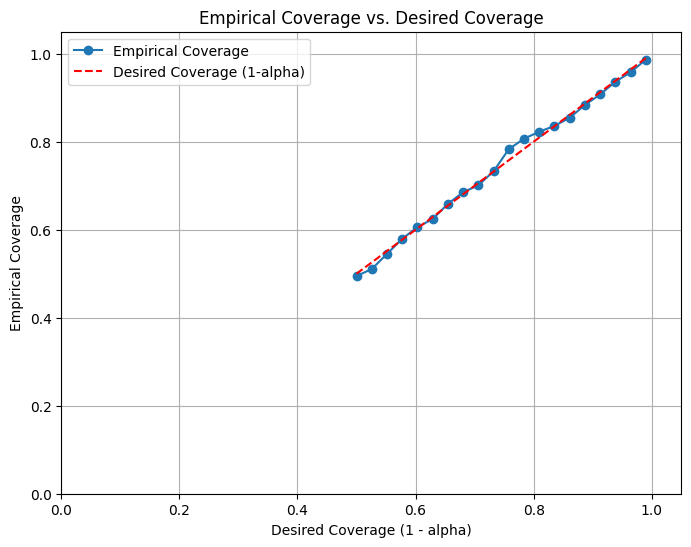

In [ ]:
alphas = np.linspace(0.01, 0.5, 20) # Test a range of alpha values from 1% to 50%
empirical_coverages = []
desired_coverages = []

for alpha in alphas:
    q_hat_index = int(np.ceil((len(nonconformity_scores) + 1) * (1 - alpha))) - 1
    if q_hat_index < 0:
        q_hat_loop = nonconformity_scores[0]
    elif q_hat_index >= len(nonconformity_scores):
        q_hat_loop = nonconformity_scores[-1]
    else:
        q_hat_loop = nonconformity_scores[q_hat_index]

    current_correct_coverage_count = 0
    current_total_samples = 0

    with torch.no_grad():
        for images, labels in final_test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = classifier_model(images).squeeze(1)
            probs_class1 = torch.sigmoid(logits)

            for j in range(images.size(0)):
                true_label = labels[j].item()
                prob_class1 = probs_class1[j].item()

                score_if_0 = prob_class1
                score_if_1 = 1 - prob_class1

                prediction_set = []
                if score_if_0 <= q_hat_loop: # Use q_hat_loop for current alpha
                    prediction_set.append(0)
                if score_if_1 <= q_hat_loop:
                    prediction_set.append(1)

                is_covered = (true_label in prediction_set)
                if is_covered:
                    current_correct_coverage_count += 1
                current_total_samples += 1

    empirical_coverage = current_correct_coverage_count / current_total_samples
    empirical_coverages.append(empirical_coverage)
    desired_coverages.append(1 - alpha)

plt.figure(figsize=(8, 6))
plt.plot(desired_coverages, empirical_coverages, marker='o', linestyle='-', label='Empirical Coverage')
plt.plot(desired_coverages, desired_coverages, color='red', linestyle='--', label='Desired Coverage (1-alpha)')
plt.title('Empirical Coverage vs. Desired Coverage')
plt.xlabel('Desired Coverage (1 - alpha)')
plt.ylabel('Empirical Coverage')
plt.grid(True)
plt.legend()
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.show()

# Conformal Prediction Giorgio

In [ ]:
classifier_model = TumorClassifier(encoder=encoder, latent_dim=128)
classifier_model.load_state_dict(torch.load('/content/autoencoder_classifier.pth'))

classifier_model.eval()

TumorClassifier(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): 

In [ ]:
# --- Assuming your TumorClassifier class (with ResNet-like head)
#     and the Autoencoder architecture are already defined.
#     Also assuming 'device' is defined ('cuda' or 'cpu').
#     And 'test_dataset' is available (e.g., from ImageFolder).

# Ensure classifier_model is loaded and on the correct device
classifier_model.to(device)
classifier_model.eval() # Set model to evaluation mode

# --- 1. Data Split (Calibration and Final Test Sets) ---
# It's crucial that the calibration set has NOT been used for training.
# We'll split the existing 'test_dataset' into calibration and final test.
# Adjust these ratios as needed. A common split is 50/50 or 60/40 for test/calibration.
# For demonstration, let's use 50% for calibration and 50% for final test.
# Ensure you have enough samples in your test_dataset for this split.

calibration_ratio = 0.5 # Proportion of test_dataset to use for calibration
num_test_samples = len(test_dataset)
num_calibration_samples = int(calibration_ratio * num_test_samples)
num_final_test_samples = num_test_samples - num_calibration_samples

# Ensure reproducibility of the split
g = torch.Generator().manual_seed(42)

calibration_dataset, final_test_dataset = random_split(
    test_dataset,
    [num_calibration_samples, num_final_test_samples],
    generator=g # Use generator for reproducible split
)

calibration_loader = DataLoader(calibration_dataset, batch_size=32, shuffle=False)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

print(f"Total test samples: {num_test_samples}")
print(f"Calibration samples: {len(calibration_dataset)}")
print(f"Final test samples: {len(final_test_dataset)}")

Total test samples: 755
Calibration samples: 377
Final test samples: 378


In [ ]:
# --- 2. Calibration Phase: Calculate Nonconformity Scores ---
nonconformity_scores = []

print("\nRunning calibration phase...")
with torch.no_grad():
    for images, labels in calibration_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = classifier_model(images).squeeze(1) # Output is [batch_size, 1], squeeze to [batch_size]
        probs_class1 = torch.sigmoid(logits) # P(Class=1)

        # Calculate nonconformity scores: 1 - P(true_class)
        # If true_label is 0, score = P(Class=1)
        # If true_label is 1, score = 1 - P(Class=1)

        # Combine using torch.where for efficiency
        # scores = torch.where(condition, value_if_true, value_if_false)
        scores_batch = torch.where(
            labels == 0,         # condition: if true label is 0
            probs_class1,        # score is P(Class=1)
            1 - probs_class1     # else (true label is 1), score is 1 - P(Class=1)
        )
        nonconformity_scores.extend(scores_batch.cpu().numpy())

# Convert to numpy array and sort
nonconformity_scores = np.array(nonconformity_scores)
nonconformity_scores.sort()


Running calibration phase...


In [ ]:
# --- 3. Quantile Calculation ---
alpha = 0.10 # Significance level (e.g., 0.10 for 90% coverage guarantee)
# Calculate the (1-alpha) quantile
# Index for the quantile calculation: (N+1)*(1-alpha)
# N is the number of calibration samples
q_hat_index = int(np.ceil((len(nonconformity_scores) + 1) * (1 - alpha))) - 1
q_hat = nonconformity_scores[q_hat_index]

print(f"\nSignificance Level (alpha): {alpha}")
print(f"Desired Coverage: {1 - alpha}")
print(f"Number of calibration scores: {len(nonconformity_scores)}")
print(f"Quantile index: {q_hat_index}")
print(f"Calculated q_hat (threshold): {q_hat:.4f}")


Significance Level (alpha): 0.1
Desired Coverage: 0.9
Number of calibration scores: 377
Quantile index: 340
Calculated q_hat (threshold): 0.1377


In [ ]:
# --- 4. Prediction Phase: Generate Prediction Sets for New Test Data ---
correct_coverage_count = 0
total_samples = 0
total_set_size = 0

print("\nRunning prediction phase on final test set...")
print("-" * 50)
print(f"{'Sample':<10} | {'True Label':<12} | {'Predicted Prob(1)':<18} | {'Pred Set':<15} | {'Coverage':<10} | {'Set Size':<10}")
print("-" * 50)

with torch.no_grad():
    for i, (images, labels) in enumerate(final_test_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = classifier_model(images).squeeze(1)
        probs_class1 = torch.sigmoid(logits) # P(Class=1)

        for j in range(images.size(0)):
            true_label = labels[j].item()
            prob_class1 = probs_class1[j].item()

            # Calculate hypothetical nonconformity scores for each class
            # Score for class 0 (assuming 0 is true) = P(Class=1)
            # Score for class 1 (assuming 1 is true) = 1 - P(Class=1)
            score_if_0 = prob_class1
            score_if_1 = 1 - prob_class1

            prediction_set = []
            if score_if_0 <= q_hat:
                prediction_set.append(0)
            if score_if_1 <= q_hat:
                prediction_set.append(1)

            # Check for coverage
            is_covered = (true_label in prediction_set)
            if is_covered:
                correct_coverage_count += 1

            total_samples += 1
            total_set_size += len(prediction_set)

            # Print results for a few samples for demonstration
            if total_samples <= 20: # Print first 20 for brevity
                print(f"{total_samples:<10} | {true_label:<12} | {prob_class1:<18.4f} | {str(prediction_set):<15} | {str(is_covered):<10} | {len(prediction_set):<10}")

print("-" * 50)


Running prediction phase on final test set...
--------------------------------------------------
Sample     | True Label   | Predicted Prob(1)  | Pred Set        | Coverage   | Set Size  
--------------------------------------------------
1          | 0            | 0.0048             | [0]             | True       | 1         
2          | 1            | 0.9542             | [1]             | True       | 1         
3          | 1            | 0.9986             | [1]             | True       | 1         
4          | 1            | 0.9994             | [1]             | True       | 1         
5          | 1            | 0.9955             | [1]             | True       | 1         
6          | 1            | 0.9808             | [1]             | True       | 1         
7          | 1            | 0.9885             | [1]             | True       | 1         
8          | 1            | 0.9818             | [1]             | True       | 1         
9          | 1            | 0.99

In [ ]:
# --- 5. Evaluation of Conformal Prediction ---
empirical_coverage = correct_coverage_count / total_samples
average_set_size = total_set_size / total_samples

print(f"\nConformal Prediction Results:")
print(f"Total samples in final test set: {total_samples}")
print(f"Empirical Coverage: {empirical_coverage:.4f} (Expected: >= {1 - alpha})")
print(f"Average Prediction Set Size: {average_set_size:.4f}")

# Example of what average set size means:
if average_set_size == 1.0:
    print("Most predictions are single-class sets (high confidence).")
elif average_set_size > 1.0 and average_set_size < 2.0:
    print("Many predictions are single-class, but some are two-class sets (uncertain).")
elif average_set_size == 2.0:
    print("All predictions are two-class sets (model is highly uncertain or q_hat is too high).")


Conformal Prediction Results:
Total samples in final test set: 378
Empirical Coverage: 0.8810 (Expected: >= 0.9)
Average Prediction Set Size: 0.8889
